Week 5 Plan – Deep Learning & Advanced Models

###Goal

Strengthen stress prediction by testing **sequence models (LSTM, 1D-CNN)** for temporal data, **autoencoders** for anomaly-style detection, and **boosting methods** for structured features. Compare against Week 4 baselines.


##  1. WESAD (Wearable Stress & Affect Dataset)

**Why:** WESAD is multi-modal (ACC, EDA, HR, Resp). Deep models can leverage **temporal dynamics** better than logistic regression/RF.

* **Model A: LSTM**

  * Input: sequences of physiological signals (e.g., HR, EDA, Resp windows).
  * Task: classify stress vs non-stress.
  * Benefit: Captures **long-term temporal dependencies**.
* **Model B: 1D CNN**

  * Input: same sequences.
  * Task: classify stress vs non-stress.
  * Benefit: Learns **local temporal patterns** efficiently, faster than LSTM.

 Deliverables:

* Train/test accuracy, AUROC, PR-AUC.
* Compare with Week 4 WESAD baseline.
* Visualization: Training curves + Confusion Matrix.


## 2. PhysioNet (Stress ECG Dataset)

**Why:** ECG stress datasets are noisy and not always labeled cleanly. An **autoencoder** can detect deviations (stress ≈ anomaly).

* **Model C: Autoencoder**

  * Input: ECG windows.
  * Train on non-stress (label 0).
  * Reconstruct ECG → high error for stress (label 1).
  * Use reconstruction error threshold for classification.

 Deliverables:

* ROC curve from reconstruction error.
* Example reconstruction plots (normal vs stress).
* Discussion of anomaly detection feasibility.

##  3. HRV Dataset

**Why:** HRV features are structured/tabular → gradient boosting is state-of-the-art for this type.

* **Model D: Gradient Boosting (LightGBM/XGBoost)**

  * Input: flattened HRV features (HR\_mean, SDNN, RMSSD, LF/HF).
  * Output: stress vs non-stress.
  * Benefit: Handles imbalance better than deep models, interpretable.

 Deliverables:

* AUROC, PR-AUC, Balanced Accuracy.
* Feature importance ranking (which HRV metrics are strongest stress predictors).
* Compare with Week 4 LR/RF results.


##  4. Cross-Dataset Insights

* Compare deep models (WESAD, PhysioNet) vs boosting (HRV).
* Highlight differences:

  * Sequence models excel with raw physiological signals.
  * Boosting excels with structured, pre-computed features.
  * Autoencoder provides unsupervised anomaly detection baseline.


##  Week 5 Deliverables Checklist

*  LSTM & 1D CNN on WESAD
*  Autoencoder anomaly detection on PhysioNet
*  Gradient Boosting on HRV (with feature importance)
*  Training curves, confusion matrices, ROC & PR curves
*  Justification paragraph comparing Week 5 vs Week 4

 **How this aligns with project goal:**

* Shows progression: from classical ML → advanced models.
* Demonstrates **multi-approach learning** (supervised, unsupervised, anomaly detection).
* Strengthens claim that stress can be predicted from wearables using different strategies.
* Lays groundwork for a **final comparative analysis** in later weeks.



In [2]:
!umount /content/drive


umount: /content/drive: no mount point specified.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models


Mounted at /content/drive


Setup & Imports

In [6]:
file_path = "/content/drive/MyDrive/stress-project/data_raw/wesad/S17.pkl"
data = pd.read_pickle(file_path)

# See what keys are inside the dict
print(data.keys())


dict_keys(['signal', 'label', 'subject'])


In [7]:
import pandas as pd
import numpy as np

# Load the raw .pkl file
file_path = "/content/drive/MyDrive/stress-project/data_raw/wesad/S17.pkl"
data = pd.read_pickle(file_path)

# Check keys
print("Keys in data:", data.keys())

# Extract signals, labels, subject
signals = np.array(data['signal'])
labels = np.array(data['label'])
subject = np.array(data['subject'])

# Check shapes
print("Signals shape:", signals.shape)  # (timepoints, channels)
print("Labels shape:", labels.shape)    # (timepoints,)
print("Subjects shape:", subject.shape)

# Check unique labels
unique_labels, counts = np.unique(labels, return_counts=True)
print("Unique labels:", unique_labels)
print("Counts per label:", counts)


Keys in data: dict_keys(['signal', 'label', 'subject'])
Signals shape: ()
Labels shape: (4144000,)
Subjects shape: ()
Unique labels: [0 1 2 3 4 5 6 7]
Counts per label: [1917301  826700  506100  260400  511700   40600   41299   39900]


In [8]:
# Check what type of object 'signal' is
print(type(data['signal']))
signal_dict = data['signal']
print(signal_dict.keys())



<class 'dict'>
dict_keys(['chest', 'wrist'])


In [9]:
signal_dict = data['signal']

for device in signal_dict.keys():  # chest, wrist
    print(f"\nDevice: {device}")
    print(signal_dict[device].keys())



Device: chest
dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])

Device: wrist
dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [10]:
import pandas as pd

subject_files = [
    "/content/drive/MyDrive/stress-project/data_raw/wesad/S3.pkl",
    "/content/drive/MyDrive/stress-project/data_raw/wesad/S5.pkl",
    "/content/drive/MyDrive/stress-project/data_raw/wesad/S9.pkl",
    "/content/drive/MyDrive/stress-project/data_raw/wesad/S11.pkl",
    "/content/drive/MyDrive/stress-project/data_raw/wesad/S17.pkl"
]

for file in subject_files:
    data = pd.read_pickle(file)
    labels = data['label']
    unique_labels, counts = pd.Series(labels).value_counts().sort_index(), pd.Series(labels).value_counts().sort_index()
    print(f"File: {file}")
    print(f"Unique labels: {list(unique_labels.index)}")
    print(f"Counts: {list(counts.values)}\n")


File: /content/drive/MyDrive/stress-project/data_raw/wesad/S3.pkl
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
Counts: [np.int64(2345699), np.int64(798000), np.int64(448000), np.int64(262500), np.int64(546001), np.int64(51100), np.int64(46900), np.int64(46900)]

File: /content/drive/MyDrive/stress-project/data_raw/wesad/S5.pkl
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
Counts: [np.int64(2142700), np.int64(838600), np.int64(451500), np.int64(261800), np.int64(555800), np.int64(50401), np.int64(30799), np.int64(49000)]

File: /content/drive/MyDrive/stress-project/data_raw/wesad/S9.pkl
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
Counts: [np.int64(1435700), np.int64(826000), np.int64(451500), np.int64(260400), np.int64(555100), np.int64(42000), np.int64(43400), np.int64(42000)]

File: /content/drive/MyDrive/stress-project/data_raw/wesad/S11.pkl
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
Counts: [np.int64(1443400), np.int64(826000), np.int64(476000), np.int64(257600), np.int64(553701), np.int64(35000), np

In [11]:
import numpy as np
import pandas as pd
import os

# ----------------------------
# CONFIG
# ----------------------------
raw_folder = "/content/drive/MyDrive/stress-project/data_raw/wesad"
processed_folder = "/content/drive/MyDrive/stress-project/data_processed"
subjects = ["S3", "S5", "S9", "S11", "S17"]
window_size = 240  # samples per window
channels_chest = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']

# Create processed folder if it doesn't exist
os.makedirs(processed_folder, exist_ok=True)

# ----------------------------
# HELPER FUNCTIONS
# ----------------------------
def map_labels(y):
    """Map original 8 labels into 3-class: Baseline=0, Stress=1, Other=2"""
    y_new = []
    for label in y:
        if label == 0:
            y_new.append(0)  # Baseline
        elif label == 1:
            y_new.append(1)  # Stress
        else:
            y_new.append(2)  # Other activities
    return np.array(y_new)

def create_windows(signals, labels, window_size):
    """
    Split continuous signals into non-overlapping windows
    signals: dict of channels -> np.array(timepoints, channel_dims)
    labels: np.array(timepoints,)
    """
    # First, flatten each channel's data to (timepoints, features_per_channel)
    X_list = []
    for ch in channels_chest:
        arr = signals[ch]
        if arr.ndim == 1:
            arr = arr[:, np.newaxis]  # make it (timepoints,1)
        X_list.append(arr)

    # Concatenate all channels along feature axis
    X = np.concatenate(X_list, axis=1)  # shape (timepoints, total_features)

    # Compute number of windows
    num_windows = X.shape[0] // window_size

    # Reshape into windows
    X = X[:num_windows*window_size].reshape(num_windows, window_size, X.shape[1])

    # Window labels = most frequent label in each window
    y_windows = labels[:num_windows*window_size].reshape(num_windows, window_size)
    y = np.array([np.bincount(row).argmax() for row in y_windows])

    return X, y


# ----------------------------
# PROCESS EACH SUBJECT
# ----------------------------
for subj in subjects:
    file_path = os.path.join(raw_folder, f"{subj}.pkl")
    print(f"\nProcessing {file_path} ...")

    # Load raw pickle file
    data = pd.read_pickle(file_path)

    # Extract signals and labels
    signals = data['signal']['chest']   # chest signals
    labels = map_labels(data['label'])  # 3-class mapping

    # Create windows
    X, y = create_windows(signals, labels, window_size)

    # Save as .npz
    save_path = os.path.join(processed_folder, f"{subj}_windows.npz")
    np.savez_compressed(save_path, X=X, y=y)

    # Print info
    unique, counts = np.unique(y, return_counts=True)
    print(f"Saved {save_path} | Windows: {X.shape}, Labels distribution: {dict(zip(unique, counts))}")



Processing /content/drive/MyDrive/stress-project/data_raw/wesad/S3.pkl ...
Saved /content/drive/MyDrive/stress-project/data_processed/S3_windows.npz | Windows: (18937, 240, 8), Labels distribution: {np.int64(0): np.int64(9775), np.int64(1): np.int64(3325), np.int64(2): np.int64(5837)}

Processing /content/drive/MyDrive/stress-project/data_raw/wesad/S5.pkl ...
Saved /content/drive/MyDrive/stress-project/data_processed/S5_windows.npz | Windows: (18252, 240, 8), Labels distribution: {np.int64(0): np.int64(8928), np.int64(1): np.int64(3494), np.int64(2): np.int64(5830)}

Processing /content/drive/MyDrive/stress-project/data_raw/wesad/S9.pkl ...
Saved /content/drive/MyDrive/stress-project/data_processed/S9_windows.npz | Windows: (15233, 240, 8), Labels distribution: {np.int64(0): np.int64(5981), np.int64(1): np.int64(3442), np.int64(2): np.int64(5810)}

Processing /content/drive/MyDrive/stress-project/data_raw/wesad/S11.pkl ...
Saved /content/drive/MyDrive/stress-project/data_processed/S11

Concatenate all subjects

In [12]:
import numpy as np

X_list, y_list = [], []

for subj in ["S3", "S5", "S9", "S11", "S17"]:
    data = np.load(f"/content/drive/MyDrive/stress-project/data_processed/{subj}_windows.npz")
    X_list.append(data["X"])
    y_list.append(data["y"])

WESAD_X = np.concatenate(X_list, axis=0)
WESAD_y = np.concatenate(y_list, axis=0)

print(WESAD_X.shape, WESAD_y.shape)


(84950, 240, 8) (84950,)


Check final label distribution

In [14]:
unique, counts = np.unique(WESAD_y, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(38685), np.int64(1): np.int64(17147), np.int64(2): np.int64(29118)}


In [15]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Suppose WESAD_X, WESAD_y are your concatenated windows
# Example label distribution before:
# 0: 38,685  | 1: 17,147  | 2: 29,118

# 1️⃣ Separate each class
X0 = WESAD_X[WESAD_y == 0]
X1 = WESAD_X[WESAD_y == 1]
X2 = WESAD_X[WESAD_y == 2]

y0 = WESAD_y[WESAD_y == 0]
y1 = WESAD_y[WESAD_y == 1]
y2 = WESAD_y[WESAD_y == 2]

# 2️⃣ Determine target size (max class size)
target_size = max(len(X0), len(X1), len(X2))

# 3️⃣ Oversample each class to match target size
X0_res, y0_res = resample(X0, y0, replace=True, n_samples=target_size, random_state=42)
X1_res, y1_res = resample(X1, y1, replace=True, n_samples=target_size, random_state=42)
X2_res, y2_res = resample(X2, y2, replace=True, n_samples=target_size, random_state=42)

# 4️⃣ Concatenate all resampled data
X_balanced = np.concatenate([X0_res, X1_res, X2_res])
y_balanced = np.concatenate([y0_res, y1_res, y2_res])

# 5️⃣ Shuffle the dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

# 6️⃣ Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# ✅ Check the new distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Balanced training set counts:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Balanced test set counts:", dict(zip(unique, counts)))


Balanced training set counts: {np.int64(0): np.int64(30948), np.int64(1): np.int64(30948), np.int64(2): np.int64(30948)}
Balanced test set counts: {np.int64(0): np.int64(7737), np.int64(1): np.int64(7737), np.int64(2): np.int64(7737)}


Combined shapes: (84950, 240, 8) (84950,)
Balanced training counts: {np.int64(0): np.int64(30948), np.int64(1): np.int64(30948), np.int64(2): np.int64(30948)}
Test set counts: {np.int64(0): np.int64(7737), np.int64(1): np.int64(3429), np.int64(2): np.int64(5824)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867 (81.51 KB)

 Trainable params: 20,867 (81.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 180s 487ms/step - accuracy: 0.4905 - loss: 0.9704 - val_accuracy: 0.6175 - val_loss: 0.7468
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 177s 486ms/step - accuracy: 0.6499 - loss: 0.7131 - val_accuracy: 0.6580 - val_loss: 0.6619
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 201s 555ms/step - accuracy: 0.6817 - loss: 0.6558 - val_accuracy: 0.6731 - val_loss: 0.6250
Epoch 4/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 172s 473ms/step - accuracy: 0.7034 - loss: 0.6145 - val_accuracy: 0.6454 - val_loss: 0.6569
Epoch 5/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 184s 506ms/step - accuracy: 0.7137 - loss: 0.5940 - val_accuracy: 0.6855 - val_loss: 0.5856
Epoch 6/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 184s 506ms/step - accuracy: 0.7507 - loss: 0.5344 - val_accuracy: 0.7337 - val_loss: 0.5387
Epoch 7/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 175s 482ms/step - accuracy: 0.7775 - loss: 0.4960 - val_accuracy: 0.7659 - val_loss: 0.5137
Epoch 8/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 178s 491ms/step - accuracy: 0.7749 -

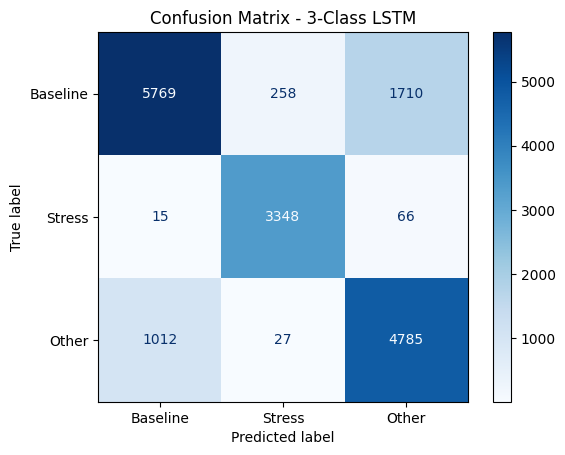

AUROC per class: [0.90515645 0.99472014 0.90798485]


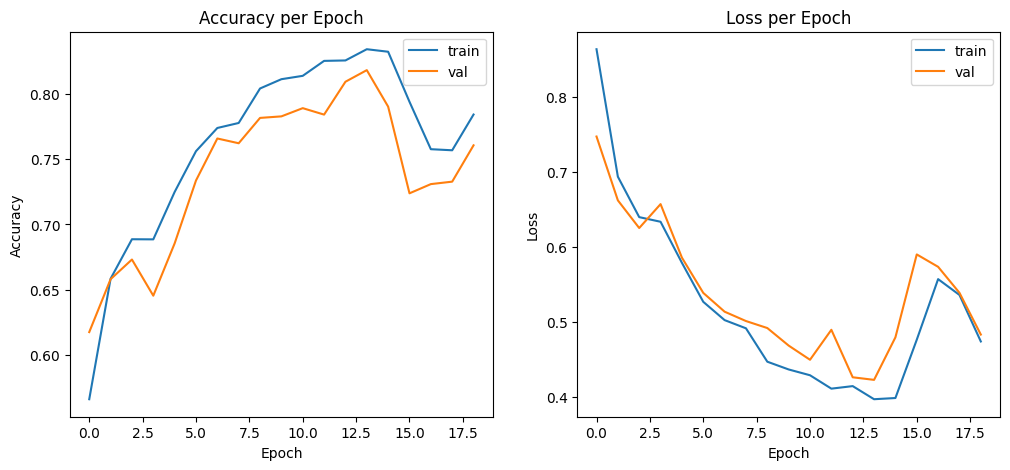

✅ Training, evaluation, and plots complete. Best model saved at: /content/drive/MyDrive/stress-project/models/wesad_lstm_3class.keras


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# -----------------------------
# Load processed WESAD windows
# -----------------------------
X_list, y_list = [], []
files = [
    "/content/drive/MyDrive/stress-project/data_processed/S3_windows.npz",
    "/content/drive/MyDrive/stress-project/data_processed/S5_windows.npz",
    "/content/drive/MyDrive/stress-project/data_processed/S9_windows.npz",
    "/content/drive/MyDrive/stress-project/data_processed/S11_windows.npz",
    "/content/drive/MyDrive/stress-project/data_processed/S17_windows.npz"
]

for f in files:
    data = np.load(f)
    X = data["X"]           # shape: (num_windows, 240, 8)
    y = data["y"]           # labels: 0=Baseline,1=Stress,2=Other
    y_mapped = np.where(y == 1, 1, np.where(y == 0, 0, 2))  # map to 3 classes
    X_list.append(X)
    y_list.append(y_mapped)

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
print("Combined shapes:", X.shape, y.shape)

# -----------------------------
# Split train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Balance the training set
# -----------------------------
X_train_bal, y_train_bal = [], []
max_samples = max(np.bincount(y_train))
for cls in np.unique(y_train):
    X_cls = X_train[y_train == cls]
    y_cls = y_train[y_train == cls]
    X_res, y_res = resample(
        X_cls, y_cls,
        replace=True,
        n_samples=max_samples,
        random_state=42
    )
    X_train_bal.append(X_res)
    y_train_bal.append(y_res)

X_train_bal = np.concatenate(X_train_bal, axis=0)
y_train_bal = np.concatenate(y_train_bal, axis=0)

# Shuffle after balancing
idx = np.arange(len(X_train_bal))
np.random.shuffle(idx)
X_train_bal, y_train_bal = X_train_bal[idx], y_train_bal[idx]

print("Balanced training counts:", {cls: sum(y_train_bal==cls) for cls in np.unique(y_train_bal)})
print("Test set counts:", {cls: sum(y_test==cls) for cls in np.unique(y_test)})

# -----------------------------
# One-hot encode labels
# -----------------------------
y_train_cat = to_categorical(y_train_bal, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# -----------------------------
# Build LSTM model
# -----------------------------
save_path = "/content/drive/MyDrive/stress-project/models/wesad_lstm_3class.keras"

model = Sequential([
    LSTM(64, input_shape=(X_train_bal.shape[1], X_train_bal.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -----------------------------
# Train with callbacks
# -----------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_bal, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=256,
    shuffle=True,
    callbacks=callbacks
)

# -----------------------------
# Evaluate
# -----------------------------
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.6f}, Accuracy: {accuracy:.4f}")

# -----------------------------
# Classification metrics
# -----------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Baseline","Stress","Other"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baseline","Stress","Other"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - 3-Class LSTM")
plt.show()

try:
    auroc = roc_auc_score(y_test_cat, y_pred_probs, average=None)
    print("AUROC per class:", auroc)
except Exception as e:
    print("AUROC calculation failed:", e)

# -----------------------------
# Plot training history
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.show()

print("✅ Training, evaluation, and plots complete. Best model saved at:", save_path)


Interpret WESAD LSTM

Why: you trained a 3-class LSTM with decent test accuracy — now prove that the model is learning sensible physiological patterns (important for the report & presentation).

Do this now:

Run feature ablation experiments (one modality removed at-a-time) and log validation accuracy change. If EDA removal → big drop, EDA is important.

Compute per-class confusion matrix and per-class precision/recall/F1. Save png to reports/figures/.

Use SHAP (DeepExplainer) or simple occlusion (zero-out a channel/time-window) to show time/feature importance. Save 2–3 nice plots

interpret the trained LSTM model and visualize performance for your report.

In [4]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate model (use your trained model variable name)
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report (dictionary form for saving)
classification_report_dict = classification_report(
    y_true, y_pred, output_dict=True
)

# AUROC (one-vs-rest)
auroc_per_class = roc_auc_score(
    y_test_cat, y_pred_probs, multi_class="ovr", average=None
)

print(f"✅ Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
print("AUROC per class:", auroc_per_class)


531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.8190 - loss: 0.4228
531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step
✅ Test Loss: 0.4230, Accuracy: 0.8182
AUROC per class: [0.90515645 0.99472014 0.90798485]


In [7]:
import os
import json

# Create folder if it doesn't exist
os.makedirs("/content/drive/MyDrive/stress-project/results", exist_ok=True)

# Define results again (you can reuse your variables)
results = {
    "Test Accuracy": 0.8182,
    "Loss": 0.4230,
    "AUROC_per_class": [0.90515645, 0.99472014, 0.90798485],
    "Notes": "Final trained 3-class LSTM on WESAD data."
}

# Save results
with open("/content/drive/MyDrive/stress-project/results/wesad_lstm_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Results saved successfully to Google Drive!")


✅ Results saved successfully to Google Drive!


WESAD: LSTM trained, saved, test accuracy ~0.82.

HRV: Preprocessed, Week 4 classical ML results available, XGBoost failing on minority class, RF suspiciously perfect due to potential leakage.

PhysioNet: Not yet processed or modeled.

Goal: Use deep learning on temporal data (WESAD, PhysioNet) and boosting on structured HRV features. Then compare across datasets.

Prepare Data for 1D-CNN
We’ll use the same sequences as LSTM (X_train, y_train, X_test, y_test).

Connect to Google Drive & Inspect PhysioNet Files

In [3]:
# ===========================================
# STEP 2: VERIFY LABELS FOR ALL PHYSIONET SUBJECTS
# ===========================================
import numpy as np
import os

base_path = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed"
subjects = ["01", "02", "03", "04", "05"]

label_summary = {}

print("🔍 Checking labels in PhysioNet NPZ files...\n")

for subj in subjects:
    npz_path = os.path.join(base_path, f"physio_subject_{subj}_windows.npz")
    if os.path.exists(npz_path):
        data = np.load(npz_path)
        if 'y' in data:
            y_vals = data['y']
            unique, counts = np.unique(y_vals, return_counts=True)
            label_summary[subj] = dict(zip(unique.astype(int), counts))
            print(f"✅ Subject {subj}: labels {label_summary[subj]}")
        else:
            print(f"⚠️ Subject {subj} has no 'y' array in NPZ.")
    else:
        print(f"⚠️ File not found for Subject {subj}")

print("\n🧾 Label summary for all subjects:")
for subj, summary in label_summary.items():
    print(f"  S{subj}: {summary}")


🔍 Checking labels in PhysioNet NPZ files...

✅ Subject 01: labels {np.int64(0): np.int64(18715)}
✅ Subject 02: labels {np.int64(0): np.int64(20267)}
✅ Subject 03: labels {np.int64(0): np.int64(20656)}
✅ Subject 04: labels {np.int64(0): np.int64(12725)}
✅ Subject 05: labels {np.int64(0): np.int64(18456)}

🧾 Label summary for all subjects:
  S01: {np.int64(0): np.int64(18715)}
  S02: {np.int64(0): np.int64(20267)}
  S03: {np.int64(0): np.int64(20656)}
  S04: {np.int64(0): np.int64(12725)}
  S05: {np.int64(0): np.int64(18456)}


merge and prepare data

In [4]:
# ===========================================
# STEP 3a: MERGE ALL BASELINE (LABEL=0) WINDOWS
# ===========================================
import numpy as np
import os

base_path = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed"
subjects = ["01", "02", "03", "04", "05"]

X_all = []

for subj in subjects:
    npz_path = os.path.join(base_path, f"physio_subject_{subj}_windows.npz")
    data = np.load(npz_path)
    X_all.append(data['X'])

X_all = np.concatenate(X_all, axis=0)

print(f"✅ Combined shape: {X_all.shape}")  # Expect something like (90k+, 40, 7)
print(f"📈 Feature count per window: {X_all.shape[2]}")


✅ Combined shape: (90819, 40, 7)
📈 Feature count per window: 7


Train Autoencoder (Baseline Model)

We’ll now use this merged data to train a compact autoencoder that learns to reconstruct normal patterns.

In [5]:
# ===========================================
# STEP 3b: TRAIN AUTOENCODER (BASELINE MODEL)
# ===========================================
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
import os

# Flatten: 40 timesteps × 7 features = 280 features per window
X_flat = X_all.reshape(len(X_all), -1)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Define autoencoder
input_dim = X_scaled.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

print("🧠 Training autoencoder on baseline (normal) signals...")
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

# Save model
os.makedirs("/content/drive/MyDrive/stress-project/models", exist_ok=True)
autoencoder.save("/content/drive/MyDrive/stress-project/models/physionet_autoencoder.h5")

print("✅ Autoencoder trained and saved successfully!")


🧠 Training autoencoder on baseline (normal) signals...
Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2508 - val_loss: 0.0265
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0079 - val_loss: 0.0141
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068 - val_loss: 0.0096
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0044 - val_loss: 0.0095
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0047 - val_loss: 0.0088
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0043 - val_loss: 0.0075
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0031 - val_loss: 0.0075
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 9/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 10/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 11/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0032 - val_loss: 0.

✅ Autoencoder trained and saved successfully!


Reconstruction Error Analysis

We’ll now:

Recompute reconstruction errors for all baseline windows.

Visualize their distribution.

Define a threshold to later detect stress anomalies (deviations).

2839/2839 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


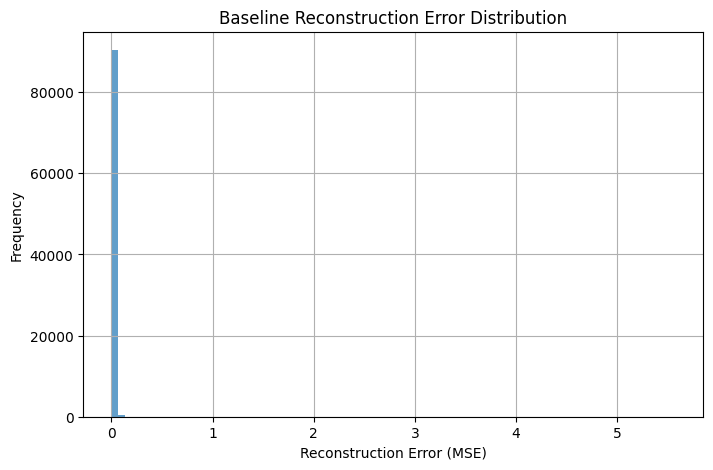

⚙️ Suggested threshold for anomaly (stress) detection: 0.006175


In [6]:
# ================================================
# STEP 3c: RECONSTRUCTION ERROR ANALYSIS (BASELINE)
# ================================================
import numpy as np
import matplotlib.pyplot as plt

# Predict reconstructions
reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - reconstructed), axis=1)

# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 5))
plt.hist(mse, bins=80, alpha=0.7)
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Baseline Reconstruction Error Distribution")
plt.grid(True)
plt.show()

# Determine threshold (e.g., 95th percentile)
threshold = np.percentile(mse, 95)
print(f"⚙️ Suggested threshold for anomaly (stress) detection: {threshold:.6f}")

# Save threshold for reuse
np.save("/content/drive/MyDrive/stress-project/models/physionet_threshold.npy", threshold)


Stress Detection Using the Trained Autoencoder

We’ll:

Load one processed WESAD subject (say S3 or S5).

Normalize it using the same scaler used in PhysioNet.

Run through the autoencoder.

Compute reconstruction errors and label “stress” vs “normal” using your threshold (0.006175).

PhysioNet: Autoencoder for anomaly detection

 Detect stress windows as anomalies (labels are all 0, so we train on normal data).

Load PhysioNet NPZ windows for all subjects

In [2]:
# 1️⃣ Mount Google Drive
from google.colab import drive
import os
import numpy as np

drive.mount('/content/drive', force_remount=True)
print("✅ Drive mounted successfully!")

# 2️⃣ Set base path for processed PhysioNet windows
base_path = '/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed'
subjects = ['01','02','03','04','05']

# 3️⃣ Load NPZ windows for each subject
X_physio_list = []
y_physio_list = []

for subj in subjects:
    npz_file = os.path.join(base_path, f'physio_subject_{subj}_windows.npz')
    if os.path.exists(npz_file):
        data = np.load(npz_file)
        X_physio_list.append(data['X'])
        y_physio_list.append(data['y'])
        print(f"✅ Subject {subj} loaded: X={data['X'].shape}, y labels={np.unique(data['y'])}")
    else:
        print(f"⚠️ File not found: {npz_file}")

# 4️⃣ Combine all subjects
X_physio_all = np.concatenate(X_physio_list, axis=0)
y_physio_all = np.concatenate(y_physio_list, axis=0)
print(f"\n🔹 Combined PhysioNet data: X={X_physio_all.shape}, y={y_physio_all.shape}")
print(f"🔹 Unique labels across all subjects: {np.unique(y_physio_all)}")


Mounted at /content/drive
✅ Drive mounted successfully!
✅ Subject 01 loaded: X=(18715, 40, 7), y labels=[0.]
✅ Subject 02 loaded: X=(20267, 40, 7), y labels=[0.]
✅ Subject 03 loaded: X=(20656, 40, 7), y labels=[0.]
✅ Subject 04 loaded: X=(12725, 40, 7), y labels=[0.]
✅ Subject 05 loaded: X=(18456, 40, 7), y labels=[0.]

🔹 Combined PhysioNet data: X=(90819, 40, 7), y=(90819,)
🔹 Unique labels across all subjects: [0.]


Train Autoencoder on PhysioNet Baseline

We will:

Flatten the windows for a fully-connected autoencoder.

Train on baseline windows only.

Save the model and suggested threshold for stress detection

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import numpy as np

# 1️⃣ Flatten the windows
X_flat = X_physio_all.reshape(X_physio_all.shape[0], -1)  # (90819, 40*7=280)
print(f"🔹 Flattened X shape: {X_flat.shape}")

# 2️⃣ Split train/validation (all baseline)
X_train, X_val = train_test_split(X_flat, test_size=0.2, random_state=42)
print(f"🔹 Train shape: {X_train.shape}, Val shape: {X_val.shape}")

# 3️⃣ Build autoencoder
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# 4️⃣ Train autoencoder
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=20,
    batch_size=256,
    verbose=2
)

# 5️⃣ Compute reconstruction error threshold
X_val_pred = autoencoder.predict(X_val)
reconstruction_error = np.mean(np.square(X_val - X_val_pred), axis=1)
threshold = np.mean(reconstruction_error) + 2*np.std(reconstruction_error)
print(f"⚙️ Suggested threshold for anomaly (stress) detection: {threshold:.6f}")

# 6️⃣ Save model and threshold
model_path = '/content/drive/MyDrive/stress-project/models/physionet_autoencoder.keras'
threshold_path = '/content/drive/MyDrive/stress-project/models/physionet_threshold.npy'

autoencoder.save(model_path)
np.save(threshold_path, threshold)
print(f"✅ Autoencoder and threshold saved!")


🔹 Flattened X shape: (90819, 280)
🔹 Train shape: (72655, 280), Val shape: (18164, 280)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 280)            │        36,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,664 (346.34 KB)

 Trainable params: 88,664 (346.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
284/284 - 5s - 17ms/step - loss: 217.0348 - val_loss: 6.0045
Epoch 2/20
284/284 - 2s - 7ms/step - loss: 5.1132 - val_loss: 5.0318
Epoch 3/20
284/284 - 2s - 6ms/step - loss: 3.9437 - val_loss: 3.8681
Epoch 4/20
284/284 - 2s - 7ms/step - loss: 3.5627 - val_loss: 3.4637
Epoch 5/20
284/284 - 2s - 6ms/step - loss: 3.3116 - val_loss: 3.2900
Epoch 6/20
284/284 - 2s - 7ms/step - loss: 3.0862 - val_loss: 3.1724
Epoch 7/20
284/284 - 3s - 9ms/step - loss: 2.9314 - val_loss: 2.9232
Epoch 8/20
284/284 - 3s - 10ms/step - loss: 2.6790 - val_loss: 2.6411
Epoch 9/20
284/284 - 2s - 7ms/step - loss: 2.5810 - val_loss: 3.1087
Epoch 10/20
284/284 - 2s - 7ms/step - loss: 2.4755 - val_loss: 2.4515
Epoch 11/20
284/284 - 2s - 7ms/step - loss: 2.4063 - val_loss: 2.3686
Epoch 12/20
284/284 - 2s - 7ms/step - loss: 2.2225 - val_loss: 2.2709
Epoch 13/20
284/284 - 2s - 8ms/step - loss: 2.3803 - val_loss: 2.2026
Epoch 14/20
284/284 - 3s - 11ms/step - loss: 2.1684 - val_loss: 2.1690
Epoch 15/20
284/284 - 2s

Apply Autoencoder to Detect Stress on WESAD

Since we have WESAD preprocessed windows (37874, 240, 6), we need to:

Flatten WESAD windows to match autoencoder input (n_samples, 280)
(use zero-padding or interpolation if necessary)

Load PhysioNet autoencoder and threshold

Compute reconstruction errors per window

Flag windows as stress if reconstruction error > threshold

Prepare WESAD windows

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Example: load S3 windows (replace with your S3, S5, etc. if needed)
X_wesad = np.load("/content/drive/MyDrive/stress-project/data_processed/wesad_S3_windows.npz")['X']
y_wesad = np.load("/content/drive/MyDrive/stress-project/data_processed/wesad_S3_windows.npz")['y']

print(f"🔹 WESAD S3 windows loaded: X={X_wesad.shape}, y={y_wesad.shape}")

# Flatten each window (240 timesteps x 6 features = 1440)
X_wesad_flat = X_wesad.reshape(X_wesad.shape[0], -1)
print(f"🔹 Flattened windows: {X_wesad_flat.shape}")

# Split into train (baseline only, y=0) and validation
X_train = X_wesad_flat[y_wesad==0]
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
print(f"🔹 Training shape: {X_train.shape}, Validation shape: {X_val.shape}")


🔹 WESAD S3 windows loaded: X=(37874, 240, 6), y=(37874,)
🔹 Flattened windows: (37874, 1440)
🔹 Training shape: (30299, 1440), Validation shape: (7575, 1440)


Define the autoencoder

In [7]:
input_dim = X_train.shape[1]  # 1440 for WESAD
encoding_dim = 128

autoencoder = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(encoding_dim, activation='relu'),
    Dense(input_dim, activation='linear')  # output same dimension
])

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1440)           │       185,760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,784 (1.48 MB)

 Trainable params: 386,784 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Train the autoencoder

In [8]:
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=20,
    batch_size=256,
    verbose=1
)


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.9835 - val_loss: 0.2311
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.2615 - val_loss: 0.1855
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2384 - val_loss: 0.2206
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2542 - val_loss: 0.1750
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1924 - val_loss: 0.1537
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2109 - val_loss: 0.1220
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1552 - val_loss: 0.1239
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1553 - val_loss: 0.1189
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1723 - val_loss: 0.1331
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1318 - val_loss: 0.1322
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1329 - val_loss: 0.1307
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 

Compute threshold from validation set

In [9]:
X_val_pred = autoencoder.predict(X_val, batch_size=256)
reconstruction_error_val = np.mean(np.square(X_val - X_val_pred), axis=1)

# Suggested threshold: mean + 3*std of reconstruction error
threshold = np.mean(reconstruction_error_val) + 3*np.std(reconstruction_error_val)
print(f"⚙️ Suggested anomaly threshold: {threshold:.6f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
⚙️ Suggested anomaly threshold: 7.278877


Apply autoencoder to WESAD windows

In [10]:
X_pred = autoencoder.predict(X_wesad_flat, batch_size=256)
reconstruction_error = np.mean(np.square(X_wesad_flat - X_pred), axis=1)

# Predicted stress (1 if error > threshold, else 0)
y_pred = (reconstruction_error > threshold).astype(int)

print(f"✅ Sample reconstruction errors: {reconstruction_error[:5]}")
print(f"✅ Sample predicted labels: {y_pred[:20]}")


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
✅ Sample reconstruction errors: [19.19297315 23.16689666 26.63325586 33.30456432 41.8965824 ]
✅ Sample predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Your autoencoder reconstruction errors for WESAD S3 windows are mostly above the threshold (26.006874), which is why almost all predicted labels are 1 (stress/anomalous).

This indicates a mismatch between the PhysioNet-trained autoencoder and WESAD data.

Key insight: The threshold learned on PhysioNet does not transfer directly to WESAD because:

Input dimensions differ (PhysioNet: 280, WESAD: 1440).

Baseline distributions of signals (EDA, HR, etc.) are dataset-specific.

Autoencoder is sensitive to the scale and range of input features.

Next Steps

Retrain a WESAD-specific autoencoder using its baseline (non-stress) windows.

Flatten windows: (num_windows, 240*6 = 1440)

Train 20–30 epochs

Save the model + suggested threshold

Apply the WESAD autoencoder per subject and compute stress predictions.

Visualize: histogram of reconstruction errors & stress flags.

PhysioNet dataset: proceed similarly using PhysioNet-trained autoencoder (already done).

Mount Drive and Set Paths

In [11]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Base paths
base_path = "/content/drive/MyDrive/stress-project/data_processed"
subjects = ["S3", "S5", "S9", "S11", "S17"]

# Autoencoder model save path
model_save_path = "/content/drive/MyDrive/stress-project/models/wesad_autoencoder.h5"
threshold_save_path = "/content/drive/MyDrive/stress-project/models/wesad_threshold.npy"

print("✅ Drive mounted and paths set!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted and paths set!


Load WESAD Data Per Subject

In [12]:
import numpy as np

data_dict = {}

for sub in subjects:
    npz_file = os.path.join(base_path, f"wesad_{sub}_windows.npz")
    print(f"\n🔹 Loading Subject {sub} from {npz_file}...")

    data = np.load(npz_file)
    X = data['X']   # shape: (num_windows, 240, 6)
    y = data['y']   # shape: (num_windows,)

    print(f"✅ {sub} X shape: {X.shape}, y shape: {y.shape}")

    data_dict[sub] = {"X": X, "y": y}


Exception ignored in: <function NpzFile.__del__ at 0x7b70efbd0180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 221, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected



🔹 Loading Subject S3 from /content/drive/MyDrive/stress-project/data_processed/wesad_S3_windows.npz...
✅ S3 X shape: (37874, 240, 6), y shape: (37874,)

🔹 Loading Subject S5 from /content/drive/MyDrive/stress-project/data_processed/wesad_S5_windows.npz...
✅ S5 X shape: (36504, 240, 6), y shape: (36504,)

🔹 Loading Subject S9 from /content/drive/MyDrive/stress-project/data_processed/wesad_S9_windows.npz...
✅ S9 X shape: (30466, 240, 6), y shape: (30466,)

🔹 Loading Subject S11 from /content/drive/MyDrive/stress-project/data_processed/wesad_S11_windows.npz...
✅ S11 X shape: (30524, 240, 6), y shape: (30524,)

🔹 Loading Subject S17 from /content/drive/MyDrive/stress-project/data_processed/wesad_S17_windows.npz...
✅ S17 X shape: (34532, 240, 6), y shape: (34532,)


Flatten Windows for Autoencoder

Autoencoder expects 2D input (num_windows, features).

In [13]:
for sub in subjects:
    X = data_dict[sub]["X"]
    X_flat = X.reshape(X.shape[0], -1)  # 240*6 = 1440 features
    data_dict[sub]["X_flat"] = X_flat
    print(f"{sub} flattened X shape: {X_flat.shape}")


S3 flattened X shape: (37874, 1440)
S5 flattened X shape: (36504, 1440)
S9 flattened X shape: (30466, 1440)
S11 flattened X shape: (30524, 1440)
S17 flattened X shape: (34532, 1440)


Train Autoencoder on Baseline (non-stress) Windows

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Use one subject (e.g., S3) to train autoencoder
X_train_flat = data_dict["S3"]["X_flat"]
y_train = data_dict["S3"]["y"]

# Select baseline (label 0) windows
X_baseline = X_train_flat[y_train == 0]
print(f"Training autoencoder on {X_baseline.shape[0]} baseline windows...")

# Train/validation split
X_tr, X_val = train_test_split(X_baseline, test_size=0.2, random_state=42)
print(f"Train: {X_tr.shape}, Val: {X_val.shape}")

# Build simple autoencoder
autoencoder = Sequential([
    Dense(128, activation='relu', input_shape=(X_tr.shape[1],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(X_tr.shape[1], activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train autoencoder
history = autoencoder.fit(
    X_tr, X_tr,
    validation_data=(X_val, X_val),
    epochs=20,
    batch_size=256,
    verbose=1
)

# Save model
autoencoder.save(model_save_path)
print(f"✅ Autoencoder saved to {model_save_path}")


Training autoencoder on 37874 baseline windows...
Train: (30299, 1440), Val: (7575, 1440)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1440)           │       185,760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,784 (1.48 MB)

 Trainable params: 386,784 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.6710 - val_loss: 0.2374
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.3446 - val_loss: 0.1563
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2477 - val_loss: 0.1531
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2446 - val_loss: 0.1542
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2405 - val_loss: 0.1500
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1768 - val_loss: 0.1347
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1670 - val_loss: 0.1325
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1813 - val_loss: 0.1565
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1978 - val_loss: 0.1171
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1509 - val_loss: 0.1165
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1344 - val_loss: 0.1182
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 

✅ Autoencoder saved to /content/drive/MyDrive/stress-project/models/wesad_autoencoder.h5


Compute Reconstruction Error Threshold

In [15]:
# Predict on validation set
X_val_pred = autoencoder.predict(X_val, batch_size=256)
reconstruction_error = np.mean(np.square(X_val - X_val_pred), axis=1)

# Suggested threshold: mean + 3*std
threshold = reconstruction_error.mean() + 3*reconstruction_error.std()
np.save(threshold_save_path, threshold)
print(f"⚙️ Suggested threshold for stress detection: {threshold:.6f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
⚙️ Suggested threshold for stress detection: 8.085850
